# Guía 7 - Pronósticos de demanda diaria con LSTM usando Keras y TensorFlow

## Pronósticos a partir de la serie temporal de la demanda diaria 

La propuesta es dar pronósticos de la demanda diaria de energía eléctrica a partir de sus valores registrados en días anteriores. Estos pronósticos lo obtendremos a partir del entrenamiento de redes neuronales (Neural Networks, NN) usando celdas del tipo *Long-Short-Time-Memory* (LSTM) y de otras configuraciones.

Continuaremos con nuestro ejemplo tomando la base de datos de demanda diaria de energía eléctrica publicados por CAMMESA [descargar](https://cammesaweb.cammesa.com/2024/12/20/covid-19-comportamiento-de-la-demanda-de-energia-electrica-en-el-mem/#).




### Inicio de la programación para el análisis y pronóstico de la series temporales

Comenzamos importando las bibliotecas necesarias y confirmamos la versión de TensorFlow (TF) disponible en la instalación. Esto nos puede ayudar a interpretar algunas diferencias en el comportamiento de las funciones de TF.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
tf.random.set_seed(99)
print(tf.__version__)

2.18.0


### Carga del conjunto de datos para su análisis

Cargamos los datos de demanda diaria desde [aquí](https://cammesaweb.cammesa.com/2024/12/20/covid-19-comportamiento-de-la-demanda-de-energia-electrica-en-el-mem/#). `DEMANDA TOTAL` es la serie que queremos predecir (target). Esperamos que sus valores históricos nos provean información para su pronóstico.   

In [2]:
# Dataset loading
dataFrame = pd.read_excel('Data/Base Demanda Diaria 2017 2024.xlsx', sheet_name='Datos Región', skiprows=4)  
dtotal = dataFrame.pop('DEMANDA TOTAL').to_numpy().reshape(-1,1)
# TF usa por default float32
dtotal = np.float32(dtotal)

Llevamos los datos al tipo `float32` ya que TF trabaja con esa precisión.

### Separación de los conjuntos de datos de entrenamiento y prueba

Como es habitual, separamos el conjunto de datos en entrenamiento y prueba. Para las series temporales se deja una porción del final como datos de prueba. Lo más importante es asegurar que el modelo se evalúa con datos futuros. Para más detalles, en particular sobre la aplicación de validación cruzada a series temporales, se puede consultar  [SciKit-Learn: Cross validation of time series data](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-of-time-series-data).

In [3]:
# Dataset splitting
SPLIT = 0.85
dtotal_len = len(dtotal)
train_set = dtotal[:int(SPLIT * dtotal_len)]
test_set = dtotal[int(SPLIT * dtotal_len):]

### Normalización de los datos

Es fundamental (y no debemos olvidarnos de) comenzar por escalar los datos para ser procesados por la NN. Sin embargo, no es necesario asumir que la distribución de datos es estacionaria como tampoco es necesario corregir por tendencias o estacionalidad...

In [4]:
train_mean = np.mean(train_set)
train_std = np.std(train_set)
print('Media: {:.0f}MW'.format(train_mean))
print('Desviación estándard: {:.0f}MW'.format(train_std))

Media: 15256MW
Desviación estándard: 2062MW


In [5]:
train_scaled = (train_set - train_mean) / train_std
test_scaled = (test_set - train_mean) / train_std

### Ventanas de datos

Lo importante es particionar la serie temporal en lotes *operables* por las sucesivas capas de NN. Es importante notar que dentro de cada lote se conserva el orden temporal...

Ilustramos el proceso de *windowing* asumiendo ventanas sucesivas de 7 datos. Así, cada lote se compone de 6 datos de entrada y un dato (el último) para las etiquetas. En este caso no se deja *offset* para comenzar con las etiquetas ni separaciones entre ventanas (*stride*).

![Ilustración de *windowing*](Figs/windowing.png)


In [6]:
# Single step dataset preparation
# The input of LSTM layer has a shape of (num_timesteps, num_features)
def singleStepSampler(df, window):
    xRes = []
    yRes = []
    for i in range(0, len(df) - window):
        res = []
        for j in range(0, window):
            res.append(df[i+j,0])
        xRes.append(res)
        yRes.append(df[i + window,0])
    return np.array(xRes), np.array(yRes)

Aplicamos las ventanas a los datos de prueba y entrenamiento. Dentro de cada ventana se arman lotes de datos de tamaño `BATCH_SIZE`. Así, `X` guardará la información de los días previos de la demanda e `y` almacenará la predicción para el día siguiente. 

In [7]:
# un ciclo completo de 4 semanas
# igual cantidad de instancias de lunes que de domingos (4)
BATCH_SIZE = 28 

(X_train, y_train) = singleStepSampler(train_scaled, BATCH_SIZE)
(X_test, y_test) = singleStepSampler(test_scaled, BATCH_SIZE)

X_train = X_train[...,np.newaxis]
y_train = y_train[...,np.newaxis]
X_test = X_test[...,np.newaxis]
y_test = y_test[...,np.newaxis]


Es interesante comparar ahora las dimensiones de los difrentes `Arrays` involucrados. Ciertamente, predecimos `DEMANDA TOTAL` en el paso siguiente... por eso también existen como atributos en el paso de tiempo anterior dentro del conjunto de datos de entrada a la NN. 

In [8]:
print('Datos de entrenamiento original de tamaño: ', train_scaled.shape)

print('Lotes de entrenamiento de tamaño: ', X_train.shape)
print('Lotes de targets de enetrenamiento de tamaño: ', y_train.shape)
print('Vemos que el `Array` se transformó en {} lotes cada uno con {} registros o instancias'.format(X_train.shape[0], BATCH_SIZE))

Datos de entrenamiento original de tamaño:  (2457, 1)
Lotes de entrenamiento de tamaño:  (2429, 28, 1)
Lotes de targets de enetrenamiento de tamaño:  (2429, 1)
Vemos que el `Array` se transformó en 2429 lotes cada uno con 28 registros o instancias


Además, confirmamos la cantidad de columnas del target y que esas columnas también están presentes en los datos de entrada... (1 columna)

Vamos a realizar un gráfico para mostrar que cada lote se va trasldando en 1 paso de tiempo...

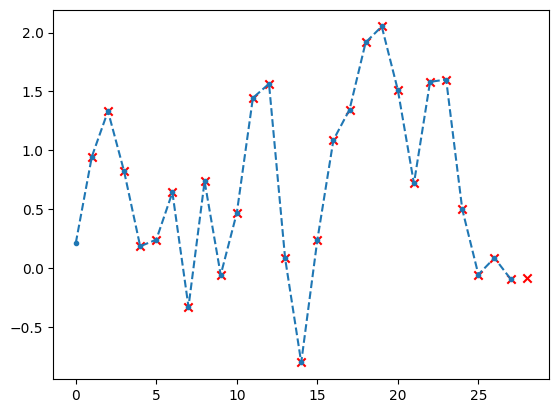

In [9]:
plt.plot(np.arange(BATCH_SIZE), train_scaled[0:BATCH_SIZE,0], linestyle='--', marker='.')
# Plot del segundo lote de datos
# Debe verse un paso de tiempo corrido
plt.scatter(np.arange(1, BATCH_SIZE+1), X_train[1, :,0], c='r', marker='x')

### Modelo multipaso, de secuencia a vector

Vamos a crear un modelo con NN que nos permitirá pronosticar el valor de `DEMANDA TOTAL` en el paso de tiempo siguiente a partir de una secuencia de datos de longitud `BATCH_SIZE`. No le vamos a decir cuántos lotes hay pero sí la dimensión de cada uno. 

### Usando la Sequential API para definir el modelo

Es una método para definir un modelo de NN que enfatiza el flujo de información secuencial desde la primera capa hacia la útlima.

Introducimos una primer capa con celdas LSTM. La capa `Dropout` no tiene parámetros o pesos ajustables. Solo permite deshabilitar aleatoriamente una fracción de las celdas. Esta técnica de tipo *ensamble* mejora la estimación final. La útlima capa es de activación lineal para dar valores continuos. Tiene 1 unidad ya que buscamos predecir los valores de `DEMANDA TOTAL` (1 columna). Es interesante notar que así, de cada lote, dará un único valor de `DEMANDA TOTAL`. Es una sequence-to-vector (multiple-input-time-step)... Esto se logra por cómo se define la NN... Sin embargo, si en la definición de la celda LSTM agregamos `return_sequence=True` entonces tendríamos una sequence-to-sequence (ver ejercicios).


In [10]:
# Definig LSTM model
multivariate_lstm = keras.Sequential()
multivariate_lstm.add(keras.layers.Input((X_train.shape[1], 1)))
multivariate_lstm.add(keras.layers.LSTM(10))
multivariate_lstm.add(keras.layers.Dropout(0.2))
multivariate_lstm.add(keras.layers.Dense(1, activation='linear'))
#multivariate_lstm.add(keras.layers.LSTM(200, return_sequences=True))
#multivariate_lstm.add(keras.layers.Dropout(0.2))
#multivariate_lstm.add(keras.layers.LSTM(20))
#multivariate_lstm.add(keras.layers.Dropout(0.2))
#multivariate_lstm.add(keras.layers.Dense(units=1))
multivariate_lstm.compile(loss = 'MeanSquaredError', metrics=['MAE'], optimizer='Adam')
multivariate_lstm.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

El método `.summary()`nos muestra cómo fluirá la información entre las capas de NN y cuántos parámetros se deberán ajustar en cada una. Otra alternativa para representar la configuración de la NN es usar `tf.keras.utils.plot_model`

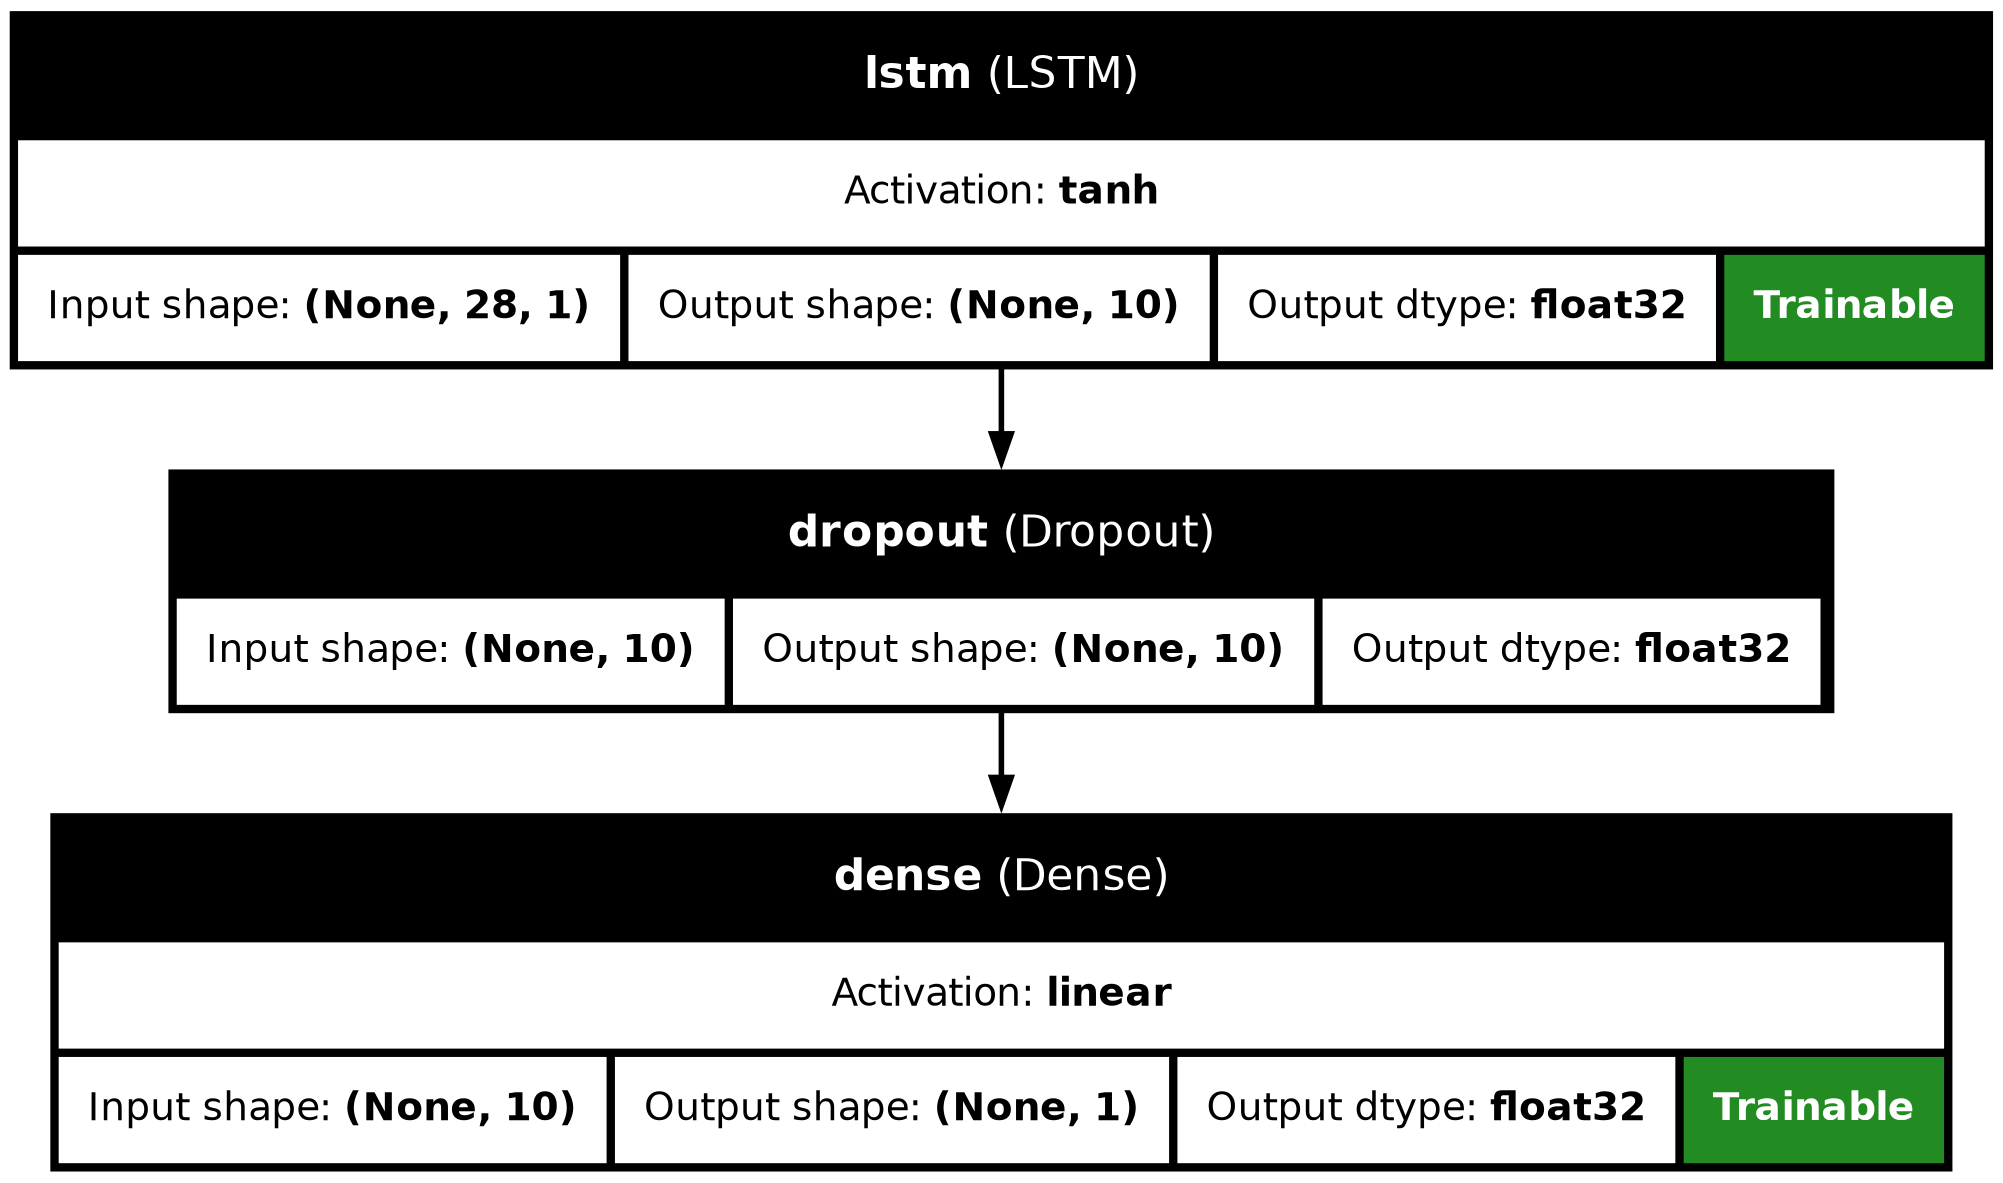

In [11]:
tf.keras.utils.plot_model(multivariate_lstm, to_file='Figs/model.png', show_shapes=True,
                          show_dtype=True, show_layer_names=True, rankdir='TB',
                          expand_nested=True, dpi=200, show_layer_activations=True,
                          show_trainable=True)

Vamos a profundizar el análisis sobre los pesos. Imprimimos sus tamaños y leeremos los pesos asignados inicialmente al *bias* tomando algunas muestras separadas de a 2 registros. 

In [12]:
# multivariate_lstm.layers[0].name
w1, w2, bias = multivariate_lstm.layers[0].get_weights()
# print(multivariate_lstm.layers[0].trainable_weights)
print(w1.shape)
print(w2.shape)
print(bias.shape)
# Pesos iniciales aleatorios y bias en 0
bias[::2] # mostramos de 2 en 2

(1, 40)
(10, 40)
(40,)


array([0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)

### Interpretación de las dimensiones de los pesos y bias

Tanto la representación de la celda LSTM 

![Celda LSTM](Figs/LSTM_weights.png)



como la forma compacta de sus ecuaciones ([Wiki-LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory)) nos muestran la existencia de 4 pesos por estado $x_t$ , 4 pesos por estado oculto $h_{t-1}$ , y 4 valores de bias. Para el ejemplo con 200 unidades resulta:

* 1 estado $x_t$ * 4 pesos * 10 unidades = 40 pesos
* 10 estados ocultos $h_{t-1}$ * 4 pesos * 10 unidades = 400 pesos
* 1 bias * 4 pesos * 10 unidades = 40 pesos

Total = 480 pesos

Además, debemos agregar los 11 pesos de la capa `Dense`.

Notamos que los bias ($b_f$) que comandan la memoria de largo plazo (*Forget gate*) se inicializan de manera opuesta, en 1, para conservar el valor inicial.

### Ajuste del modelo

Entrenamos el modelo, es decir, ajustamos los pesos de acuerdo al esquema definido cuando fue compilado, por ejemplo `optimizer='Adam'`.

In [13]:

# Model training
history = multivariate_lstm.fit(X_train, y_train, epochs=30, validation_split=0.1)

# early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
# history = multivariate_lstm.fit(X_train, y_train, epochs=3000, validation_split=0.1, callbacks=[early_stopping_cb])


Epoch 1/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - MAE: 0.7089 - loss: 0.8165 - val_MAE: 0.7695 - val_loss: 1.0739
Epoch 2/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - MAE: 0.5993 - loss: 0.6111 - val_MAE: 0.7070 - val_loss: 0.8571
Epoch 3/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - MAE: 0.5754 - loss: 0.5570 - val_MAE: 0.6747 - val_loss: 0.7573
Epoch 4/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - MAE: 0.5548 - loss: 0.5175 - val_MAE: 0.6501 - val_loss: 0.6914
Epoch 5/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - MAE: 0.5582 - loss: 0.5151 - val_MAE: 0.6292 - val_loss: 0.6425
Epoch 6/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - MAE: 0.5559 - loss: 0.5137 - val_MAE: 0.6093 - val_loss: 0.5999
Epoch 7/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - MAE: 0.5416 - loss: 0.4800 - val_MAE: 0.5887 - val_loss: 0.5585
Epoch 8/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - MAE: 0.5338 - loss: 0.4628 - val_MAE: 0.5694 - val_loss: 0.5225
Epoch 9/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - MAE: 0.5287 

Para tener una idea sobre la convergencia del moelo, mostramos las curvas de aprendizaje

(0.0, 1.0)

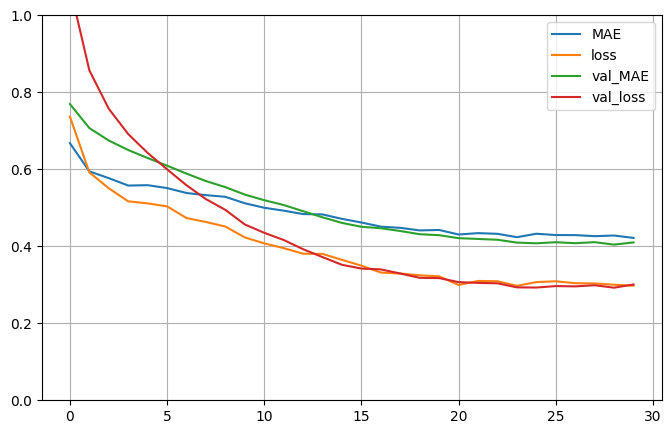

In [14]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)

Luego que el modelo ha sido ajustado, es muy fácil obtener nuevas predicciones, como por ejemplo cuando le pasamos el conjunto de prueba.

In [15]:
# Forecast Plot with Dates on X-axis
predicted_values = multivariate_lstm.predict(X_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [16]:
print('Dimensión de los datos de prueba ', X_test.shape)
print('Dimensión de los datos de las predicciones ', predicted_values.shape)

Dimensión de los datos de prueba  (406, 28, 1)
Dimensión de los datos de las predicciones  (406, 1)


Vemos como de cada lote se obtiene un único valor por la configuración de la red como sequence-to-vector

### Evaluación de los resultados

Ahora vamos a representar nuestro resultado. Construimos un `DataFrame` para almacenar los valores de `DEMANDA TOTAL` predecida y observada, y su fecha (que recuperamos de los datos originales). Este `DataFrame` nos facilitará el cálculo de distintas métricas que califican el grado de acuerdo de las predicciones del modelo con los valores registrados. Asimismo, representaremos en una figura ambas series de datos para tener una estimación visual del desempeño del modelo.  

In [17]:
# Forecast Plot with Dates on X-axis
LSTM_eval = pd.DataFrame({
    'Predicted_DEMANDA': predicted_values[:, 0],
    'Actual_DEMANDA': y_test[:, 0],
})

LSTM_eval.loc[:, 'Date'] = dataFrame['Fecha'][-len(y_test):].values
# LSTM_eval.set_index('Date', inplace=True)
LSTM_eval['Date'] = pd.to_datetime(LSTM_eval['Date'])
LSTM_eval.dtypes


Predicted_DEMANDA           float32
Actual_DEMANDA              float32
Date                 datetime64[ns]
dtype: object

In [18]:
LSTM_eval.set_index('Date', inplace=True)
LSTM_eval

,Predicted_DEMANDA,Actual_DEMANDA
Date,,
2023-10-22,-0.713967,-0.766311
2023-10-23,-0.760272,-0.216194
2023-10-24,-0.184140,-0.363576
2023-10-25,-0.626150,-0.542809
2023-10-26,-0.529356,-0.502893
...,...,...
2024-11-26,0.978460,0.960365
2024-11-27,0.288191,0.761229
2024-11-28,0.493399,0.519004


In [19]:
# Creamos una figura para representar las series de datos
def FigPredActual(d, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    #  highlight the  forecast
    # highlight_start = int(len(d) * 0.9)  
    # highlight_end = len(d) - 1  # Adjusted to stay within bounds
    # Plot the actual values
    # plt.plot(d[['Actual_DEMANDA']][:highlight_start], label=['Actual_DEMANDA'])
    plt.plot(d[['Actual_DEMANDA']], label=['Actual_DEMANDA'])
    
    # Plot predicted values with a dashed line
    plt.plot(d[['Predicted_DEMANDA']], label=['Predicted_DEMANDA'], linestyle='--')
    
    # Highlight the forecasted portion with a different color
    # plt.axvspan(d.index[highlight_start], d.index[highlight_end], facecolor='lightgreen', alpha=0.5, label='Forecast')
    
    plt.title(title)
    plt.xlabel('Dates')
    plt.ylabel('Values')
    ax.legend()

Trazamos ambas series de datos

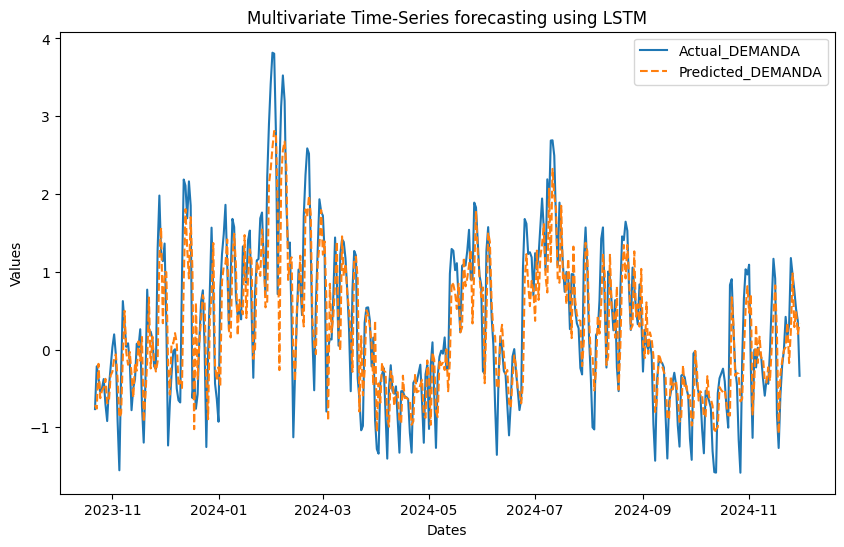

In [20]:
FigPredActual(LSTM_eval, 'Multivariate Time-Series forecasting using LSTM')

Definimos una función conveniente para calcular diferentes métrias que nos informan sobre el grado de acuerdo de las predicciones del modelo con las observaciones

In [21]:
# Model Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def performance(d):
    return {
        'MSE': mean_squared_error(d['Actual_DEMANDA'].to_numpy(), d['Predicted_DEMANDA'].to_numpy()),
        'MAE': mean_absolute_error(d['Actual_DEMANDA'].to_numpy(), d['Predicted_DEMANDA'].to_numpy()),
        'R2': r2_score(d['Actual_DEMANDA'].to_numpy(), d['Predicted_DEMANDA'].to_numpy())
    }

performance(LSTM_eval)

{'MSE': 0.3080826699733734, 'MAE': 0.413912832736969, 'R2': 0.7054493427276611}

También podemos usar el método `.evaluate()` de TF para recuperar las métricas usadas en el ajuste sobre el conjunto de Test.

In [22]:
multivariate_lstm.evaluate(X_test, y_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - MAE: 0.4334 - loss: 0.3370 


[0.308082640171051, 0.413912832736969]

**Ejercicios**

1. Reemplazar la capa LSTM por una más simple del tipo `keras.layers.SimpleRNN`. Analizar la cantidad de parámetros o pesos de calibración.

2. Reponer nuevamente la capa del tipo `keras.layers.LSTM` pero en este caso definir 100 o 200 unidades. Evaluar sus resultados.

3. Probar de entrenar nuevamente el mismo modelo con `.fit()` (sin redefinir). Confirmar que el ajuste avanza desde los valores de los pesos asignados para el último valor de `epoch`. Observar las nuevas curvas de aprendizaje. ¿Logra converger a mejores métricas?

4. Proponer sobre el mismo modelo anterior un método de `callback` que pare el ajuste cuando se den condiciones de convergencia. Evaluar sus resultados. Aumentar el número asignado a `epochs` ya que esperamos la finalización por convergencia. 

5. Probar un modelo que agrega una 2da capa de celdas LSTM. Notar que para pasar los datos (el lote completo) a la 2da capa se debe definir `return_seguences=True` en la 1ra. Evaluar sus resultados.

6. Elaborar un ciclo que reutilice el último valor pronosticado como entrada de un nuevo pronóstico. Esta es una estrategia que permite obtener pronósticos para más de un tiempo en adelante (aunque con error creciente). 

7. Desarrollar un modelo con 2 unidades en la última capa (densa) de manera de realizar pronósticos para los 2 pasos de tiempo siguientes. Modificar convenientemente la función `singleStepSampler()` para que devuelva 2 valores por lote para los conjuntos `y_train` e `y_test`. Esta es otra estrategia alternativa para el pronóstico de valores en tiempos futuros manteniendo un esquema sequence-to-vector. 

8. Probar un modelo sequence-to-sequence. Esto permite obtner prónosticos para varios pasos de tiempo por delante bajo una sola ejecución. Primero, definimos `return_sequences=True` en todas las capas LSTM. Notar que además de igualar la cantidad de unidades de la capa `Dense` al tamaño de la secuencia de salida agregamos `tf.keras.layers.TimeDistributed` para operar sobre cada corte de tiempo. Además, debemos editar la función `singleStepSampler()` para que devuelva tantos *targets* como la longitud de la secuencia de salida (`multiStepSampler()`). Evaluar sus resultados solo sobre un paso de tiempo adelante para comparar con las predicciones del modelo sequence-to-vector.


## Generación de resultados de referencia

Para valorar la calidad de las predicciones debemos comparar los resultados con valores de referencia o *baseline*. Estos se obtienen a partir de modelos sencillos y de fácil interpretación (*benchmark*). Se desea que los modelos más avanzados puedan superar las predicciones de los modelos simples. Esto otorga un criterio cunatitativo para la selección de modelos.

### Baseline que repite el último valor

Vamos a probar con un modelo Baseline que simplemente repite el útlimo valor de una semana atrás. Aquí tenemos en cuenta que la demanda dependerá fuertemente del día de la semana. Otra opción es repetir el último valor de la serie (se desecha el impacto de los fines de semana).

### Aprovechando la Subclassing API para crear modelos dinámicos

Algunas veces, nuestros modelos necesitarán del uso de lazos, condicionales u otros comportamientos dinámicos. Para estos casos, disponemos de la **Subclassing API** que aquí aprovecharemos para definir nuestro modelo Baseline (aunque es un ejemplo muy sencillo).

La clase contiene un método `__init__()` que habitualmente se usa para declarar las capas involucradas. La arquitectura del modelo queda *oculta* dentro del método `__call_()`. Si bien tiene mayor flexibilidad, cuesta detectar errores y el modelo es menos transportable (con la función `save()`). 

Seguidamente, se compila, ajusta y evalúa de manera análoga a los modelos anteriores.

In [23]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs[:, -7, 0][...,np.newaxis]
    return tf.gather(inputs, indices=tf.constant(self.label_index), axis=2)[:, -7, :]

# Instantiate and evaluate this model:

baseline = Baseline()
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

# Forecast Plot with Dates on X-axis
baseline_values = baseline.predict(X_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [24]:
baseline_values.shape

(406, 1)

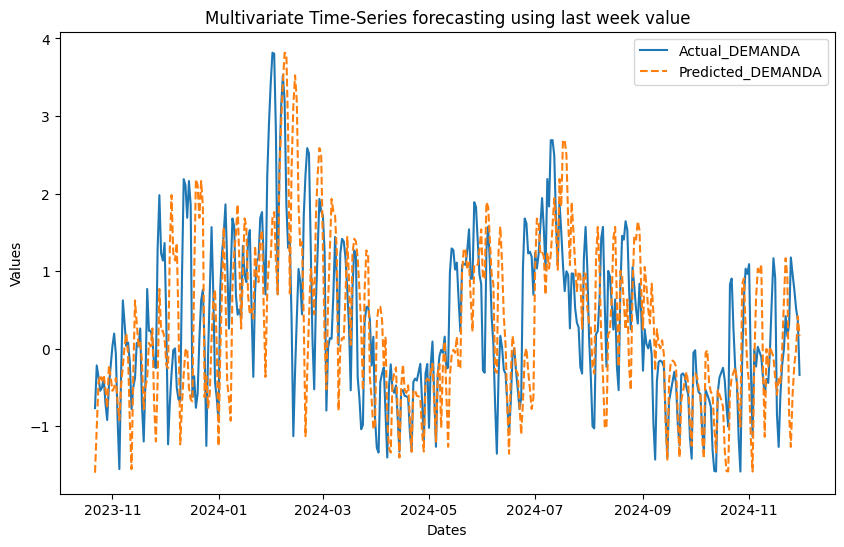

In [25]:
Base_eval = LSTM_eval.copy()
Base_eval['Predicted_DEMANDA'] = baseline_values[:, 0]

FigPredActual(Base_eval, 'Multivariate Time-Series forecasting using last week value')


In [26]:
performance(Base_eval)

{'MSE': 0.9689379334449768,
 'MAE': 0.7399710416793823,
 'R2': 0.07362091541290283}

**Ejercicio**

9. Recalcular las métricas anteriores para una referencia (*baseline*) que repite el valor observado en el día inmediatamente anterior.

10. ecalcular las métricas anteriores para una referencia (baseline) que siempre predice el valor medio de la serie de entrenamiento. Interpretar la información que recuperamos de estas propuestas.

### Baseline multipaso con una red densa

Proponemos un nuevo benchmark basado en un *modelo lineal* que realiza sus predicciones accediendo a los valores anteriores. Es una versión simplificada de la celda LSTM ya que no realimenta sus salidas (no hay memoria, solo información de contexto). Es un modelo multipaso ya que sus entradas toman los valores instantaneos en pasos de tiempo anteriores. Por el contrario, recordamos que un modelo de un solo paso no tiene información de contexto. No puede *ver* cómo los valores de entrada van cambiando con el tiempo. En el modelo multipaso esperamos poder mejorar el entrenamiento y la predicción en el paso siguiente conociendo la historia de los valores que lo precedieron.

Aquí usamos nuevamente un modelo secuencial. Esencialmente, convierte los recortes de la serie temporal de tamaño `BATCH_SIZE` en una tira de datos. La expectativa es encontrar pesos adecuados para las entradas vinculadas a valores en pasos anteriores y recuperar así una correcta serie de salida.

In [27]:
# Defining a Dense model
univariate_dense = keras.Sequential([
    keras.layers.Input((X_train.shape[1], 1)),
    tf.keras.layers.Flatten(),
    keras.layers.Dense(1, activation='linear')
])

univariate_dense.compile(loss = 'MeanSquaredError', metrics=['MAE'], optimizer='Adam')
univariate_dense.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 28)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            29 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29 (116.00 B)

 Trainable params: 29 (116.00 B)

 Non-trainable params: 0 (0.00 B)

In [28]:
#Model training
history = univariate_dense.fit(X_train, y_train, epochs=30, validation_split=0.1)


Epoch 1/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - MAE: 1.0042 - loss: 1.6094 - val_MAE: 0.8899 - val_loss: 1.3304
Epoch 2/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MAE: 0.7253 - loss: 0.8905 - val_MAE: 0.7875 - val_loss: 1.0266
Epoch 3/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MAE: 0.6381 - loss: 0.7083 - val_MAE: 0.7150 - val_loss: 0.8628
Epoch 4/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MAE: 0.5872 - loss: 0.6040 - val_MAE: 0.6631 - val_loss: 0.7548
Epoch 5/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MAE: 0.5509 - loss: 0.5339 - val_MAE: 0.6250 - val_loss: 0.6752
Epoch 6/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MAE: 0.5227 - loss: 0.4812 - val_MAE: 0.5939 - val_loss: 0.6120
Epoch 7/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MAE: 0.4987 - loss: 0.4389 - val_MAE: 0.5670 - val_loss: 0.5601
Epoch 8/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MAE: 0.4778 - loss: 0.4042 - val_MAE: 0.5443 - val_loss: 0.5167
Epoch 9/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MAE: 0.4601 - loss: 

In [29]:
# Forecast Plot with Dates on X-axis
dense_values = univariate_dense.predict(X_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


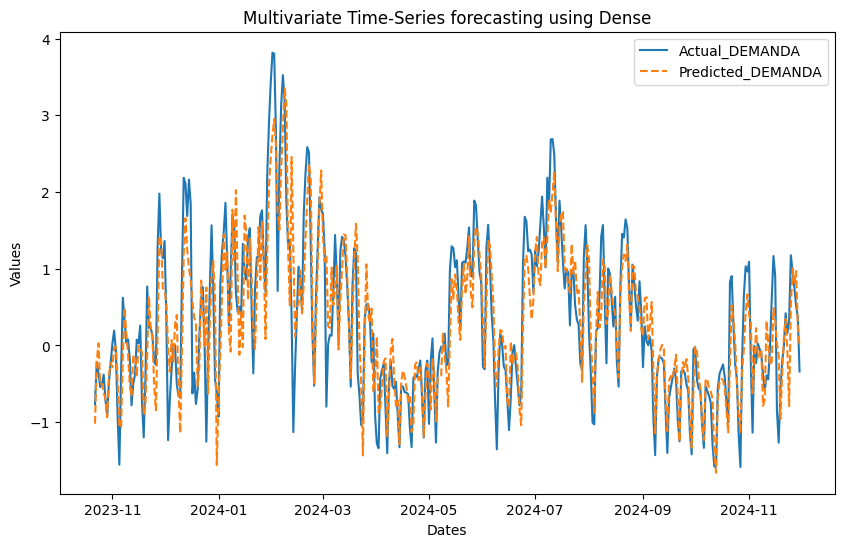

In [30]:
Dense_eval = LSTM_eval.copy()
Dense_eval['Predicted_DEMANDA'] = dense_values[:, 0]

FigPredActual(Dense_eval, 'Multivariate Time-Series forecasting using Dense')

In [31]:
performance(Dense_eval)

{'MSE': 0.27363690733909607, 'MAE': 0.3883194327354431, 'R2': 0.73838210105896}

**Ejercicio**

11. Recalcular las métricas anteriores para una referencia (baseline) que considere el siguiente modelo denso algo más potente

In [32]:
# Testear el siguiente modelo denso algo más potente
univariate_dense2 = tf.keras.Sequential([
    keras.layers.Input((X_train.shape[1], 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

**Pregunta**

1. ¿Pueden los modelos que usan redes neuronales recurrentes superar a los predicciones más simples? ¿Cómo informaría los resultados hallados? Proponer un ejemplo.
2. ¿Considera que la serie temporal de `DEMANDA TOTAL` puede ser predecida en base a la información de contexto pasada? ¿Se podría acotar la incertidumbre? En otras palabras, ¿por qué esperamos superar a los modelos benchmark? 
3. ¿Cuál es la importancia de los valores iniciales asignados de manera aleatoria a los pesos? ¿y si se continúa ajustando sin redefinir el modelo?
4. ¿Puede tener impacto variar el tamaño `BATCH_SIZE`? Realice algunas pruebas.
